# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab link: https://colab.research.google.com/drive/1wiWUs8rcAbS3dnb80ixUH9XRkyj_6Nex?usp=sharing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [7]:
has=True

for line in open('SMSSpamCollection'):
  if (line.split()[0]=="ham") and has:
    print("Non-spam is ",line)
    has=False
  elif (line.split()[0]=="spam"):
    print("Spam is ",line)
    break

Non-spam is  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam is  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



**Answer:**

the label for spam is "spam", and the label for non-spam is "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [8]:
spam = 0
ham = 0

for line in open('SMSSpamCollection'):
  if line.split()[0] == "spam":
    spam += 1
  else:
    ham += 1

print("Number of spam messages:", spam)
print("Number of non-spam messages:", ham)

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [9]:
# Load raw data into lists
sequences = []
labels = []

with open('SMSSpamCollection', 'r', encoding='utf-8') as f:
    for line in f:
        # split only on the first tab
        label, text = line.strip().split('\t', 1)
        sequences.append(text)
        labels.append(0 if label == 'ham' else 1)

# Build character-level vocab (reserve 0 for padding)
all_chars = sorted(set("".join(sequences)))
stoi = {'<pad>': 0}
for idx, ch in enumerate(all_chars, start=1):
    stoi[ch] = idx
itos = {idx: ch for ch, idx in stoi.items()}

# Convert each message to a list of character IDs
seq_ids = [[stoi[ch] for ch in msg] for msg in sequences]

# Labels are already 0 (ham) or 1 (spam)
label_ids = labels

print(f"Total messages: {len(seq_ids)}")
print(f"  Spam: {sum(label_ids)}")
print(f"  Ham:  {len(label_ids) - sum(label_ids)}")
print(f"Vocab size (incl. padding): {len(stoi)}")
print("First 2 sequences as ID lists:", seq_ids[:2])
print("First 2 labels:", label_ids[:2])
print("Sample stoi entries:", list(stoi.items())[:5])
print("Sample itos entries:", list(itos.items())[:5])

Total messages: 5574
  Spam: 747
  Ham:  4827
Vocab size (incl. padding): 117
First 2 sequences as ID lists: [[40, 79, 1, 85, 78, 84, 73, 76, 1, 74, 85, 82, 79, 78, 71, 1, 80, 79, 73, 78, 84, 13, 1, 67, 82, 65, 90, 89, 15, 15, 1, 34, 86, 65, 73, 76, 65, 66, 76, 69, 1, 79, 78, 76, 89, 1, 73, 78, 1, 66, 85, 71, 73, 83, 1, 78, 1, 71, 82, 69, 65, 84, 1, 87, 79, 82, 76, 68, 1, 76, 65, 1, 69, 1, 66, 85, 70, 70, 69, 84, 15, 15, 15, 1, 36, 73, 78, 69, 1, 84, 72, 69, 82, 69, 1, 71, 79, 84, 1, 65, 77, 79, 82, 69, 1, 87, 65, 84, 15, 15, 15], [48, 75, 1, 76, 65, 82, 15, 15, 15, 1, 43, 79, 75, 73, 78, 71, 1, 87, 73, 70, 1, 85, 1, 79, 78, 73, 15, 15, 15]]
First 2 labels: [0, 0]
Sample stoi entries: [('<pad>', 0), (' ', 1), ('!', 2), ('"', 3), ('#', 4)]
Sample itos entries: [(0, '<pad>'), (1, ' '), (2, '!'), (3, '"'), (4, '#')]


### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [11]:
from sklearn.model_selection import train_test_split
from random import shuffle
import random
random.seed(42)

In [12]:
# build the list of all indices
x = seq_ids
y = label_ids
all_index = list(range(len(x)))

# 60% train / 40% temp (stratified)
train_index, temp_index = train_test_split(
    all_index,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# Split temp 50/50 → 20% val, 20% test
val_index, test_index = train_test_split(
    temp_index,
    test_size=0.5,
    stratify=[y[i] for i in temp_index],
    random_state=42
)

train_x = [x[idx] for idx in train_index]
train_y = [y[idx] for idx in train_index]
val_x   = [x[idx] for idx in val_index]
val_y   = [y[idx] for idx in val_index]
test_x  = [x[idx] for idx in test_index]
test_y  = [y[idx] for idx in test_index]

#Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)

# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

# shuffle the balanced train set
combined = list(zip(train_x, train_y))
shuffle(combined)
train_x, train_y = zip(*combined)
train_x, train_y = list(train_x), list(train_y)

# check
print(f"Train ham: {train_y.count(0)}, spam: {train_y.count(1)}")
print(f"Val ham: {val_y.count(0)}, spam: {val_y.count(1)}")
print(f"Test ham: {test_y.count(0)}, spam: {test_y.count(1)}")

Train ham: 2896, spam: 3136
Val ham: 965, spam: 150
Test ham: 966, spam: 149


In [13]:
train_ds = (train_x, train_y)
valid_ds = (val_x, val_y)
test_ds = (test_x, test_y)

### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [14]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        sequences: list of lists of character IDs (integers)
        labels:    list of 0/1 integers
        """
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # return (sequence, label) for index idx
        return self.sequences[idx], self.labels[idx]

def collate_sequences(batch):
    """
    batch: list of (sequence, label) pairs, where
      - sequence is a list of ints
      - label is an int
    Returns:
      padded_seqs: LongTensor of shape (batch_size, max_len)
      lengths: LongTensor of shape (batch_size,)
      labels: LongTensor of shape (batch_size,)
    """
    # unzip into two tuples
    seqs, labels = zip(*batch)

    # convert each seq list -> tensor
    seq_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs]

    # pad to the same length
    # pad_sequence defaults to padding_value=0 (our <pad> token index)
    padded_seqs = pad_sequence(seq_tensors, batch_first=True, padding_value=0)

    # record original lengths (so RNN pack_padded_sequence can use them)
    lengths = torch.tensor([len(s) for s in seq_tensors], dtype=torch.long)

    # labels tensor
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_seqs, lengths, labels

In [15]:
train_loader = DataLoader(
    dataset=MyDataset(train_x, train_y),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_sequences
)
val_loader = DataLoader(
    dataset=MyDataset(val_x, val_y),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_sequences
)
test_loader = DataLoader(
    dataset=MyDataset(test_x, test_y),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_sequences
)

In [16]:
train = MyDataset(*train_ds)
valid = MyDataset(*valid_ds)
test = MyDataset(*test_ds)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [20]:
for i, (padded_seqs, lengths, labels) in enumerate(train_loader):
    if i >= 10:
        break
    # padded_seqs shape: (batch_size, max_seq_len)
    batch_size, max_len = padded_seqs.size()
    # count pad tokens (whose index is 0)
    pad_count = (padded_seqs == 0).sum().item()
    print(f"Batch {i+1:2d}: max_seq_len = {max_len:4d}, pad_tokens = {pad_count:4d}")

Batch  1: max_seq_len =  160, pad_tokens = 1611
Batch  2: max_seq_len =  329, pad_tokens = 7264
Batch  3: max_seq_len =  166, pad_tokens = 1688
Batch  4: max_seq_len =  162, pad_tokens = 2159
Batch  5: max_seq_len =  174, pad_tokens = 1901
Batch  6: max_seq_len =  162, pad_tokens =  787
Batch  7: max_seq_len =  166, pad_tokens = 2161
Batch  8: max_seq_len =  161, pad_tokens = 2480
Batch  9: max_seq_len =  160, pad_tokens = 1720
Batch 10: max_seq_len =  181, pad_tokens = 2435


In [ ]:
# for batch in train_loader:
#     ...

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [18]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [34]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1, dropout: float = 0.1, num_classes: int = 2):
        """
        A bidirectional LSTM + max+avg pooling classifier over one-hot char inputs.
        Args:
            input_size:   size of char vocab (len(stoi))
            hidden_size:  # hidden units per LSTM direction
            num_layers:   # stacked LSTM layers
            dropout:      dropout on the pooled rep
            num_classes:  # output classes (2 for ham/spam)
        """
        super().__init__()
        self.name = "SpamDetectorRNN"
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.register_buffer('emb', torch.eye(input_size))
        # zero out the <pad> vector at index 0
        self.emb[0].zero_()

        # bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )

        # dropout on the pooled rep
        self.dropout = nn.Dropout(dropout)

        # pooled rep dim = hidden_size*2 (directions) * 2 (max+avg)
        self.fc = nn.Linear(hidden_size * 2 * 2, num_classes)

    def forward(self, x: torch.LongTensor, lengths: torch.LongTensor) -> torch.Tensor:
        """
        x: LongTensor[B, L] of char IDs (0 is pad)
        lengths: LongTensor[B] of original sequence lengths
        returns: logits [B, num_classes]
        """
        # one-hot → [B, L, V]
        x_onehot = self.emb[x]

        # pack padded batch
        packed = pack_padded_sequence(x_onehot, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)

        # unpack → [B, L, H*2]
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        # max-pool and avg-pool over time
        max_rep, _ = out.max(dim=1)           # [B, H*2]
        # sum then divide by length → [B, H*2]
        sum_rep    = out.sum(dim=1)
        avg_rep    = sum_rep / lengths.unsqueeze(1)

        # concat → [B, H*2*2]
        rep = torch.cat([max_rep, avg_rep], dim=1)
        rep = self.dropout(rep)

        return self.fc(rep) # [B, num_classes]

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [37]:
def get_accuracy(model, loader):
    """
    Compute classification accuracy of `model` over data in `loader` on CPU.

    Args:
        model:  your RNN instance
        loader: DataLoader yielding (padded_seqs, lengths, labels)

    Returns:
        accuracy (float): correct / total
    """
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for padded_seqs, lengths, labels in loader:
            logits = model(padded_seqs, lengths) # (B, num_classes)
            preds  = logits.argmax(dim=1) # (B,)

            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [24]:
import matplotlib.pyplot as plt

In [45]:
def train_rnn_network(model, train_loader, valid_loader, batch_size, num_epochs=5, learning_rate=1e-5):
    """
    Train an RNN, track loss/accuracy, save checkpoints locally,
    and plot curves at the end.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses = [], []
    train_accs,  valid_accs  = [], []
    epochs = list(range(1, num_epochs + 1))

    for epoch in epochs:
        model.train()
        total_train_loss = 0.0
        for padded_seqs, lengths, labels in train_loader:
            optimizer.zero_grad()
            logits = model(padded_seqs, lengths)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * labels.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_valid_loss = 0.0
        with torch.no_grad():
            for padded_seqs, lengths, labels in valid_loader:
                logits = model(padded_seqs, lengths)
                loss = criterion(logits, labels)
                total_valid_loss += loss.item() * labels.size(0)
        avg_valid_loss = total_valid_loss / len(valid_loader.dataset)
        valid_losses.append(avg_valid_loss)

        train_acc = get_accuracy(model, train_loader)
        valid_acc = get_accuracy(model, valid_loader)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        print(f"Epoch {epoch}/{num_epochs}  "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}  |  "
              f"Val Loss:   {avg_valid_loss:.4f}, Val Acc:   {valid_acc:.4f}")

        ckpt_name = f"{model.name}_bs{batch_size}_lr{learning_rate}_ep{epoch}.pt"
        torch.save(model.state_dict(), ckpt_name)

    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, valid_accs, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Answer:**

Experiment 1 (128, 32, 1e-3, 10 epoch) was a quick sanity check—model already hit ~95 % after one pass.

Epoch 1/10  Train Loss: 0.3610, Train Acc: 0.9473  |  Val Loss:   0.1750, Val Acc:   0.9552
Epoch 2/10  Train Loss: 0.1863, Train Acc: 0.9586  |  Val Loss:   0.1997, Val Acc:   0.9578
Epoch 3/10  Train Loss: 0.1278, Train Acc: 0.9619  |  Val Loss:   0.1044, Val Acc:   0.9605
Epoch 4/10  Train Loss: 0.1072, Train Acc: 0.9750  |  Val Loss:   0.0868, Val Acc:   0.9776
Epoch 5/10  Train Loss: 0.0692, Train Acc: 0.9809  |  Val Loss:   0.1017, Val Acc:   0.9758
Epoch 6/10  Train Loss: 0.0467, Train Acc: 0.9924  |  Val Loss:   0.0559, Val Acc:   0.9857
Epoch 7/10  Train Loss: 0.0307, Train Acc: 0.9947  |  Val Loss:   0.0697, Val Acc:   0.9839
Epoch 8/10  Train Loss: 0.0231, Train Acc: 0.9985  |  Val Loss:   0.0718, Val Acc:   0.9883
Epoch 9/10  Train Loss: 0.0234, Train Acc: 0.9990  |  Val Loss:   0.0605, Val Acc:   0.9883
Epoch 10/10  Train Loss: 0.0095, Train Acc: 0.9972  |  Val Loss:   0.0731, Val Acc:   0.9874


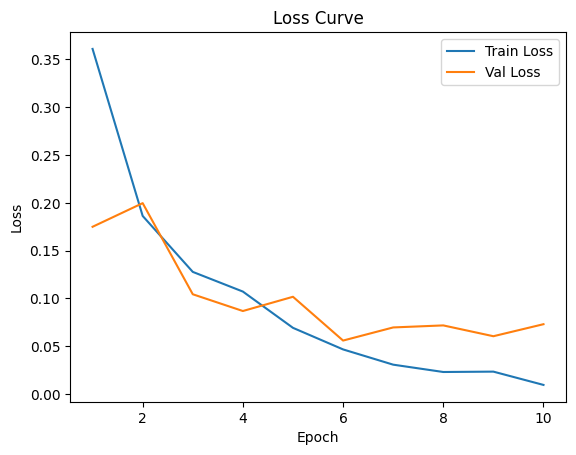

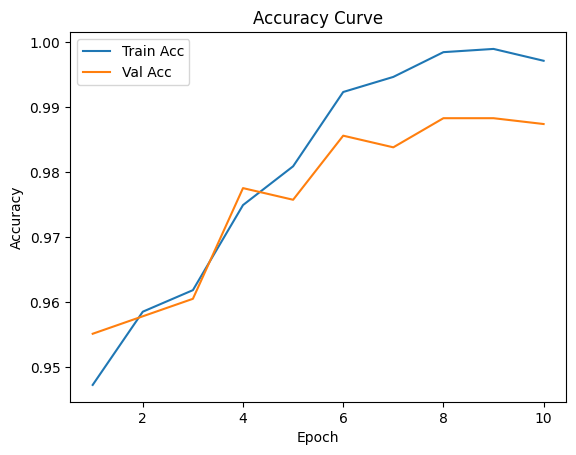

In [40]:
# 1. hidden units=128, batch size=32, learning rate=1e-3, number of epochs=10(due to google colab usage limit and the really long running time)

model = RNN(input_size=len(stoi), hidden_size=128)
train_rnn_network(
    model,
    train_loader,
    val_loader,
    batch_size=32,
    num_epochs=10,
    learning_rate=1e-3
)

**Answer:**

Experiment 2 lowered the learning rate (5e-5) and ran 10 epochs to smooth training; convergence was slow, topping out near 95.9 %.

Epoch 1/10  Train Loss: 0.6860, Train Acc: 0.5199  |  Val Loss:   0.7204, Val Acc:   0.1345
Epoch 2/10  Train Loss: 0.5381, Train Acc: 0.9388  |  Val Loss:   0.3114, Val Acc:   0.9516
Epoch 3/10  Train Loss: 0.2161, Train Acc: 0.9460  |  Val Loss:   0.2370, Val Acc:   0.9327
Epoch 4/10  Train Loss: 0.2193, Train Acc: 0.9491  |  Val Loss:   0.1926, Val Acc:   0.9570
Epoch 5/10  Train Loss: 0.2104, Train Acc: 0.9474  |  Val Loss:   0.1781, Val Acc:   0.9561
Epoch 6/10  Train Loss: 0.1888, Train Acc: 0.9491  |  Val Loss:   0.1647, Val Acc:   0.9578
Epoch 7/10  Train Loss: 0.1799, Train Acc: 0.9506  |  Val Loss:   0.1668, Val Acc:   0.9587
Epoch 8/10  Train Loss: 0.2663, Train Acc: 0.8722  |  Val Loss:   0.3074, Val Acc:   0.8287
Epoch 9/10  Train Loss: 0.2093, Train Acc: 0.9471  |  Val Loss:   0.1487, Val Acc:   0.9507
Epoch 10/10  Train Loss: 0.1681, Train Acc: 0.9532  |  Val Loss:   0.1827, Val Acc:   0.9444


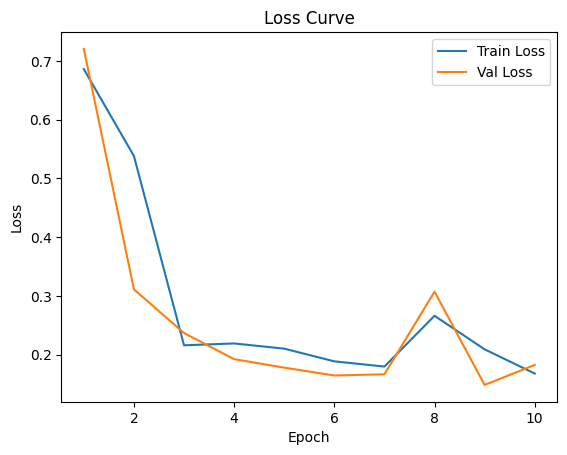

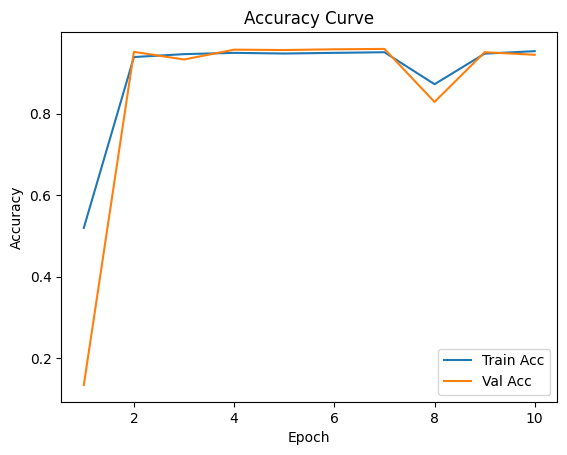

In [41]:
# 2. hidden units=128, batch size=32, learning rate=5e-5, number of epochs=10

model = RNN(input_size=len(stoi), hidden_size=128)
train_rnn_network(
    model,
    train_loader,
    val_loader,
    batch_size=32,
    num_epochs=10,
    learning_rate=5e-5
)

**Answer:**

Experiment 3 cut hidden units to 64 (same lr & batch), which reduced overfitting and gave a really good peak val acc so far (≈98.5 % at epoch 6).

Epoch 1/10  Train Loss: 0.3935, Train Acc: 0.9088  |  Val Loss:   0.2091, Val Acc:   0.9767
Epoch 2/10  Train Loss: 0.1675, Train Acc: 0.9340  |  Val Loss:   0.0813, Val Acc:   0.9803
Epoch 3/10  Train Loss: 0.1032, Train Acc: 0.9738  |  Val Loss:   0.1426, Val Acc:   0.9659
Epoch 4/10  Train Loss: 0.0789, Train Acc: 0.9849  |  Val Loss:   0.0697, Val Acc:   0.9794
Epoch 5/10  Train Loss: 0.0542, Train Acc: 0.9862  |  Val Loss:   0.0940, Val Acc:   0.9785
Epoch 6/10  Train Loss: 0.0350, Train Acc: 0.9942  |  Val Loss:   0.0607, Val Acc:   0.9848
Epoch 7/10  Train Loss: 0.0253, Train Acc: 0.9954  |  Val Loss:   0.0815, Val Acc:   0.9794
Epoch 8/10  Train Loss: 0.0240, Train Acc: 0.9894  |  Val Loss:   0.1269, Val Acc:   0.9623
Epoch 9/10  Train Loss: 0.0125, Train Acc: 0.9975  |  Val Loss:   0.0851, Val Acc:   0.9830
Epoch 10/10  Train Loss: 0.0136, Train Acc: 0.9942  |  Val Loss:   0.1196, Val Acc:   0.9686


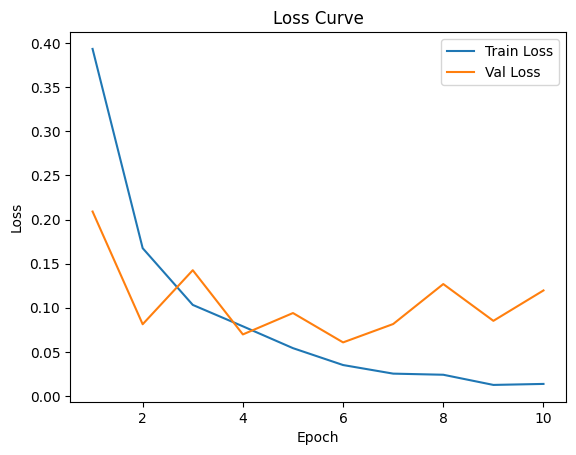

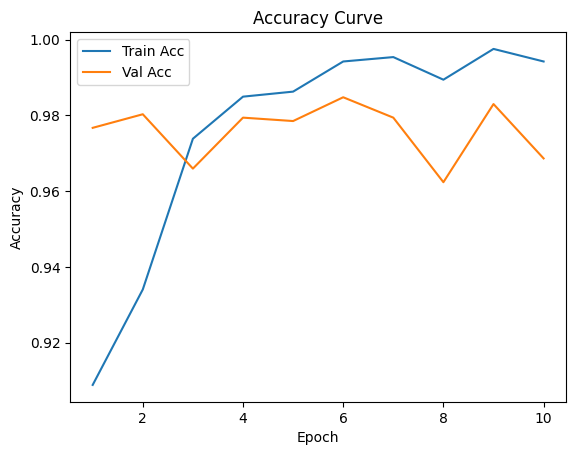

In [43]:
# 3. hidden units=64, batch size=32, learning rate=1e-3, number of epochs=10

model = RNN(input_size=len(stoi), hidden_size=64)
train_rnn_network(
    model,
    train_loader,
    val_loader,
    batch_size=32,
    num_epochs=10,
    learning_rate=1e-3
)

**Answer:**

Experiment 4 doubled batch size to 64 to speed up gradient estimates; it achieved ~98.8 %, close to the smaller‐model optimum.

The final model I choose is this hidden units=128, batch size=64, learning rate=1e-3, at the last epoch.

Epoch 1/10  Train Loss: 0.4338, Train Acc: 0.9057  |  Val Loss:   0.2966, Val Acc:   0.9776
Epoch 2/10  Train Loss: 0.2227, Train Acc: 0.9378  |  Val Loss:   0.2071, Val Acc:   0.9803
Epoch 3/10  Train Loss: 0.1481, Train Acc: 0.9627  |  Val Loss:   0.1249, Val Acc:   0.9659
Epoch 4/10  Train Loss: 0.1126, Train Acc: 0.9687  |  Val Loss:   0.0765, Val Acc:   0.9803
Epoch 5/10  Train Loss: 0.0929, Train Acc: 0.9733  |  Val Loss:   0.0798, Val Acc:   0.9830
Epoch 6/10  Train Loss: 0.0740, Train Acc: 0.9791  |  Val Loss:   0.0773, Val Acc:   0.9839
Epoch 7/10  Train Loss: 0.0594, Train Acc: 0.9836  |  Val Loss:   0.0650, Val Acc:   0.9874
Epoch 8/10  Train Loss: 0.0450, Train Acc: 0.9912  |  Val Loss:   0.0733, Val Acc:   0.9821
Epoch 9/10  Train Loss: 0.0348, Train Acc: 0.9932  |  Val Loss:   0.0750, Val Acc:   0.9839
Epoch 10/10  Train Loss: 0.0258, Train Acc: 0.9949  |  Val Loss:   0.0975, Val Acc:   0.9731


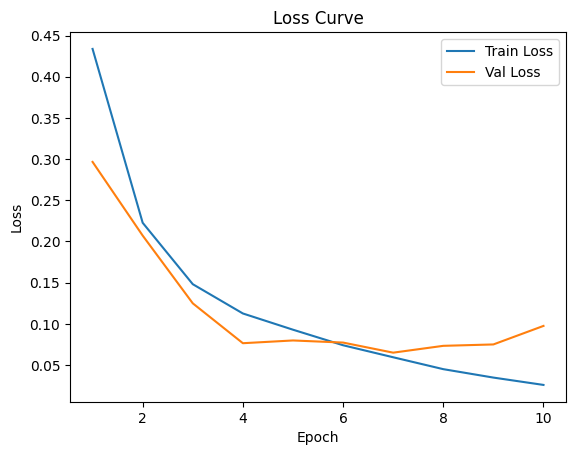

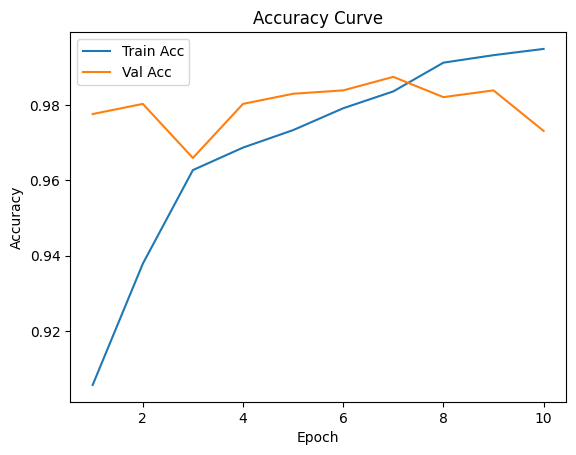

In [44]:
# 4. hidden units=128, batch size=64, learning rate=1e-3, number of epochs=10

batch_size = 64

# rebuild loaders with the new batch size
train_loader = DataLoader(
    MyDataset(*train_ds),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_sequences
)
val_loader = DataLoader(
    MyDataset(*valid_ds),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_sequences
)
test_loader = DataLoader(
    MyDataset(*test_ds),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_sequences
)

model = RNN(input_size=len(stoi), hidden_size=128)

train_rnn_network(
    model,
    train_loader,
    val_loader,
    batch_size=batch_size,
    num_epochs=10,
    learning_rate=1e-3
)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [46]:
model = RNN(input_size=len(stoi), hidden_size=128)
checkpoint_path = "/content/SpamDetectorRNN_bs64_lr0.001_ep9.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
model.eval()

TP = TN = FP = FN = 0

with torch.no_grad():
    for padded_seqs, lengths, labels in val_loader:
        logits = model(padded_seqs, lengths)
        preds = logits.argmax(dim=1)

        # vectorized counting
        is_spam = labels == 1
        is_ham = labels == 0
        pred_spam = preds == 1
        pred_ham = preds == 0

        TP += int((is_spam & pred_spam).sum())
        FN += int((is_spam & pred_ham).sum())
        TN += int((is_ham & pred_ham).sum())
        FP += int((is_ham & pred_spam).sum())

false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0.0
false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0.0

print(f"Validation set size: {FP+TN+TP+FN}")
print(f"False Positive Rate (FP / (FP+TN)): {false_positive_rate:.4f}")
print(f"False Negative Rate (FN / (FN+TP)): {false_negative_rate:.4f}")

Validation set size: 1115
False Positive Rate (FP / (FP+TN)): 0.0093
False Negative Rate (FN / (FN+TP)): 0.0600


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:**

* False Positive (Type I Error):
A legitimate (ham) message is mislabeled as spam and hidden from the user. They may miss or delay important personal or business communications.

* False Negative (Type II Error):
An actual spam message is mislabeled as ham and delivered to the inbox. The user endures unwanted or potentially malicious content in their main message stream.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [47]:
model = RNN(input_size=len(stoi), hidden_size=128)

checkpoint_path = "/content/SpamDetectorRNN_bs64_lr0.001_ep9.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
model.eval()

test_accuracy = get_accuracy(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")

Final Test Accuracy: 97.67%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [49]:
model = RNN(input_size=len(stoi), hidden_size=128)
checkpoint_path = "/content/SpamDetectorRNN_bs64_lr0.001_ep9.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
model.eval()

# compute false positives/negatives on the test set
TP = TN = FP = FN = 0

with torch.no_grad():
    for padded_seqs, lengths, labels in test_loader:
        logits = model(padded_seqs, lengths)
        preds = logits.argmax(dim=1)

        is_spam = labels == 1
        is_ham = labels == 0
        pred_spam = preds == 1
        pred_ham = preds == 0

        TP += int((is_spam & pred_spam).sum())
        FN += int((is_spam & pred_ham).sum())
        TN += int((is_ham & pred_ham).sum())
        FP += int((is_ham & pred_spam).sum())

false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0.0
false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0.0

print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")

False Positive Rate: 0.0155
False Negative Rate: 0.0738


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [50]:
msg = "machine learning is sooo cool!"

In [51]:
model = RNN(input_size=len(stoi), hidden_size=128)

checkpoint = "/content/SpamDetectorRNN_bs64_lr0.001_ep9.pt"
model.load_state_dict(torch.load(checkpoint, map_location="cpu"))
model.eval()

# convert each character to its ID (unknown chars → 0)
ids = [stoi.get(ch, 0) for ch in msg]
seq = torch.tensor([ids], dtype=torch.long) # shape: [1, L]
lengths = torch.tensor([len(ids)], dtype=torch.long) # shape: [1]

# forward-pass & compute prob
with torch.no_grad():
    logits = model(seq, lengths)
    probs = F.softmax(logits, dim=1)

# spam probability
spam_prob = probs[0, 1].item()
print(f"Model’s predicted P(spam) for \"{msg}\": {spam_prob:.4f}")

Model’s predicted P(spam) for "machine learning is sooo cool!": 0.1209


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer:**

* Spam detection is a challenging task, spammers constantly come up with new tricks, language is highly variable, and class imbalance can mislead models. A robust system must adapt to unseen phrasing and adversarial examples.

* Based on my research, a simple baseline is a Naïve Bayes classifier. First, tokenize each SMS into words and build two frequency tables: one counting how often each word appears in spam and one for non-spam. To classify a new message, look up each word’s relative frequency in both tables, combine those frequencies into an overall spam score and a non-spam score, then choose the higher score. Apply simple smoothing so that words unseen in training don’t zero-out your score. This method requires only counting and basic arithmetic, making it fast and easy to implement.